# Unit Test 2

Topics covered:

* Logistic Regression
* Resampling Methods
* Subset Selection
* Shrinkage Methods

## Background
The study of Near-Earth Objects (NEOs) is critical to ensuring future planetary security from impacts by asteroids. Predicting potential impacts may seem as if it is a straightforward task but the number of variables involved in the process leads to quite a bit of uncertainty. Because of this, the Center for NEO Studies (https://cneos.jpl.nasa.gov/about/cneos.html) and NASA's Jet Propulsion Laboratory has been logging data about asteroids and whether they meet the classification of hazardous or not. The data is provided on Canvas.

### Dataset
`nasa.csv`

## Task
Your goal is to construct a model that effectively predicts whether an asteroid is hazardous or not. Ideally, you will find a relatively simple (i.e. interpretable) model, such that we don't need to collect every variable below to make a prediction (hint: subset selection and/or shrinkage would be useful for this). The fewer variables we have to collect, the more asteroids we'll be able to observe. I would also like you to utilize PCA to select some number of principal components and try a logistic regression with those as predictor variables.

I'm looking for a well-constructed logistic regression, whose assumptions have been checked, with strong cross-validated accuracy and an interpretation of the coefficients. 

In [2]:
## Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
import statsmodels.api as sm
import numpy as np

In [3]:
## Data Preparation
df = pd.read_csv('nasa.csv')
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [4]:
## Clean Data
df['Hazardous'] = df['Hazardous'].astype(int)
df = pd.get_dummies(df, columns=['Orbiting Body', 'Equinox'], drop_first=True)

       Neo Reference ID          Name  Absolute Magnitude  Est Dia in KM(min)  \
count      4.687000e+03  4.687000e+03         4687.000000         4687.000000   
mean       3.272298e+06  3.272298e+06           22.267865            0.204604   
std        5.486011e+05  5.486011e+05            2.890972            0.369573   
min        2.000433e+06  2.000433e+06           11.160000            0.001011   
25%        3.097594e+06  3.097594e+06           20.100000            0.033462   
50%        3.514799e+06  3.514799e+06           21.900000            0.110804   
75%        3.690060e+06  3.690060e+06           24.500000            0.253837   
max        3.781897e+06  3.781897e+06           32.100000           15.579552   

       Est Dia in KM(max)  Est Dia in M(min)  Est Dia in M(max)  \
count         4687.000000        4687.000000        4687.000000   
mean             0.457509         204.604203         457.508906   
std              0.826391         369.573402         826.391249   
mi

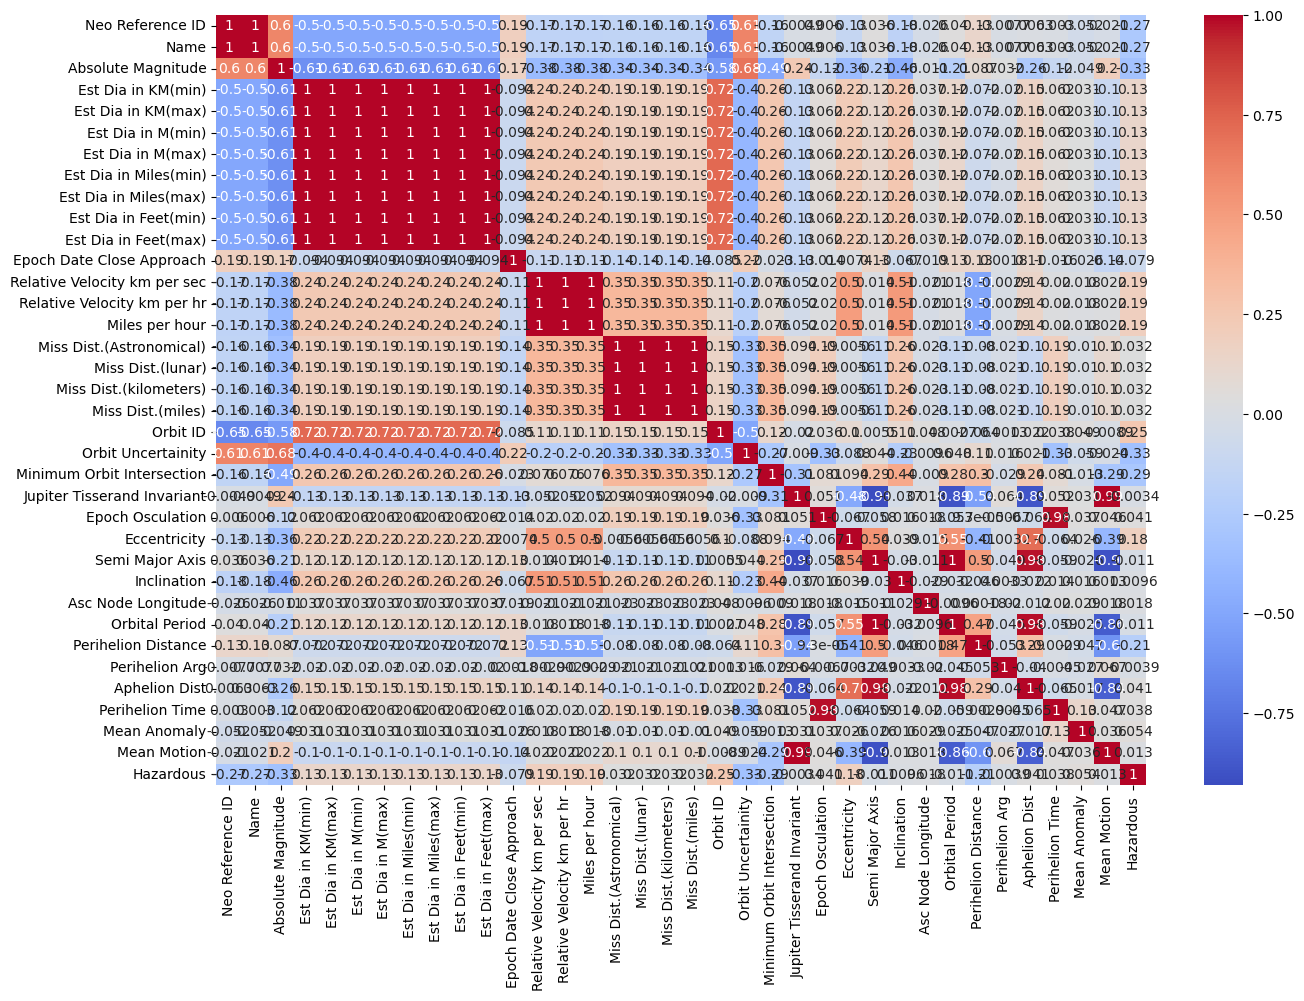

In [5]:
## Exploratory Data Analysis (EDA)
print(df.describe())
print(df.info())
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

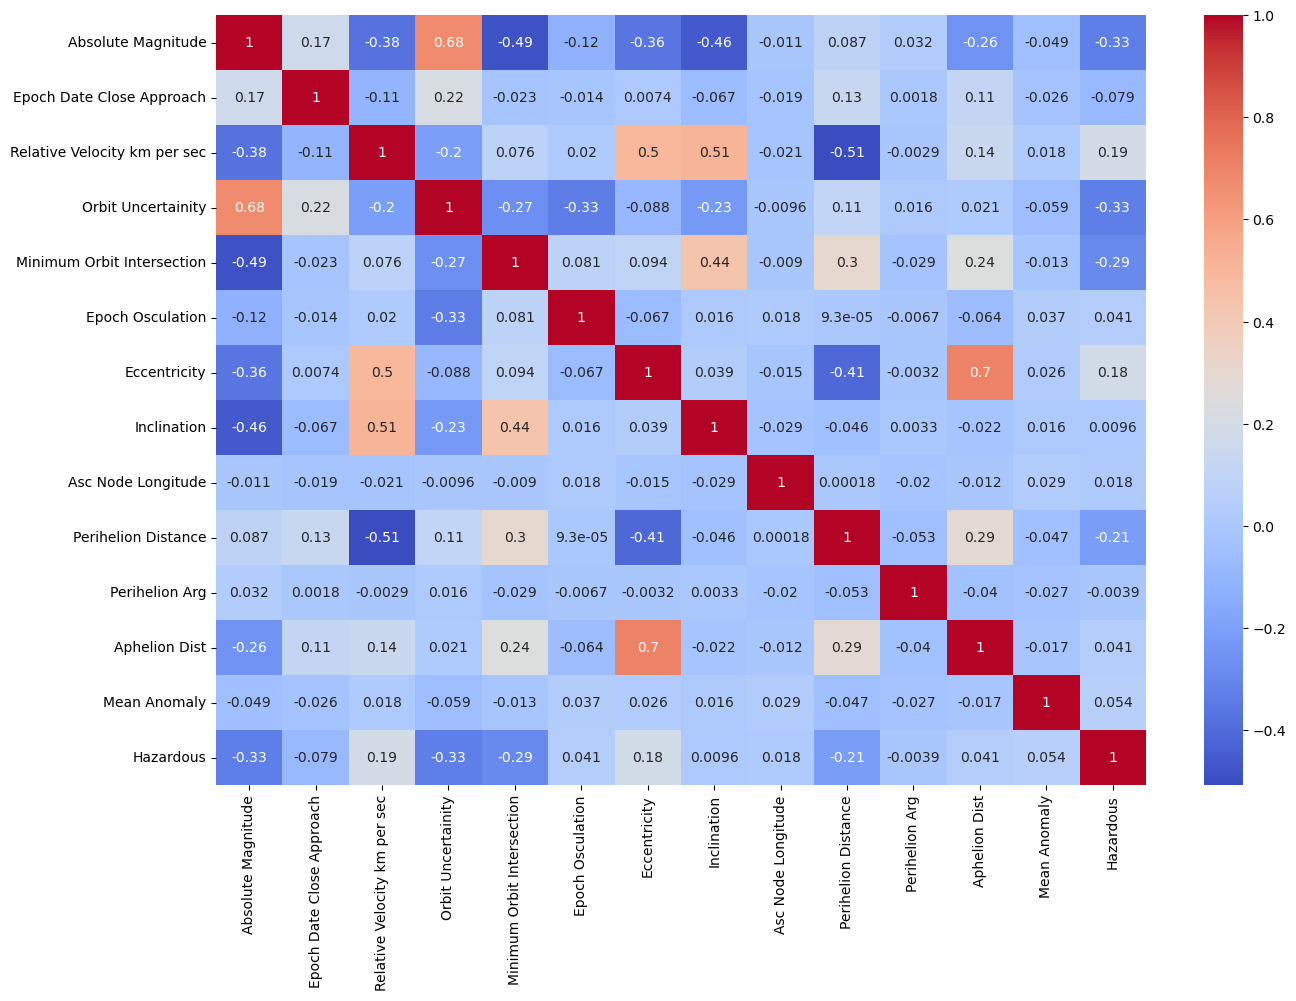

In [6]:
cols_to_drop = ['Neo Reference ID', 'Name', 'Orbit ID', 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Relative Velocity km per hr', 'Miles per hour', 'Jupiter Tisserand Invariant', 'Perihelion Time', 'Orbital Period', 'Semi Major Axis', 'Mean Motion']

cols_to_check = df.select_dtypes(include=['float64', 'int64']).columns
cols_to_check = cols_to_check.drop(cols_to_drop)
corr_matrix = df[cols_to_check].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [7]:
## Feature Selection
X = df.drop(columns=['Close Approach Date', 'Orbit Determination Date', 'Hazardous', 'Neo Reference ID', 'Name', 'Orbit ID', 'Miss Dist.(Astronomical)', 'Miss Dist.(lunar)', 'Miss Dist.(kilometers)', 'Miss Dist.(miles)', 'Est Dia in KM(min)', 'Est Dia in KM(max)', 'Est Dia in M(min)', 'Est Dia in M(max)', 'Est Dia in Miles(min)', 'Est Dia in Miles(max)', 'Est Dia in Feet(min)', 'Est Dia in Feet(max)', 'Relative Velocity km per hr', 'Miles per hour', 'Jupiter Tisserand Invariant', 'Perihelion Time', 'Orbital Period', 'Semi Major Axis', 'Mean Motion'])
y = df['Hazardous']


lr = LogisticRegression(max_iter=10000)
sfs = SequentialFeatureSelector(lr, n_features_to_select=10, direction='forward')
sfs.fit(X, y)
selected_features = X.columns[sfs.get_support()]

In [8]:
## Principal Component Analysis (PCA)
pca = PCA(n_components=10)
principal_components = pca.fit_transform(X)

In [9]:
## Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [10]:
## Model Evaluation
cv_scores = cross_val_score(lr, X_train, y_train, cv=5)
print(f'Cross-validated accuracy: {cv_scores.mean()}')

Cross-validated accuracy: 0.8378235870048956


In [11]:
## Interpretation and Reporting
coeffs = pd.DataFrame(lr.coef_, columns=selected_features)
print(coeffs)

   Absolute Magnitude  Epoch Date Close Approach  \
0       -3.915808e-23              -1.412591e-12   

   Relative Velocity km per sec  Orbit Uncertainity  \
0                  1.442220e-24       -1.816281e-23   

   Minimum Orbit Intersection  Epoch Osculation  Eccentricity   Inclination  \
0               -4.746338e-25     -2.852331e-18  2.711205e-26 -1.471091e-23   

   Asc Node Longitude  Perihelion Distance  
0       -2.009682e-22        -1.591355e-24  


Optimization terminated successfully.
         Current function value: 0.124463
         Iterations 12


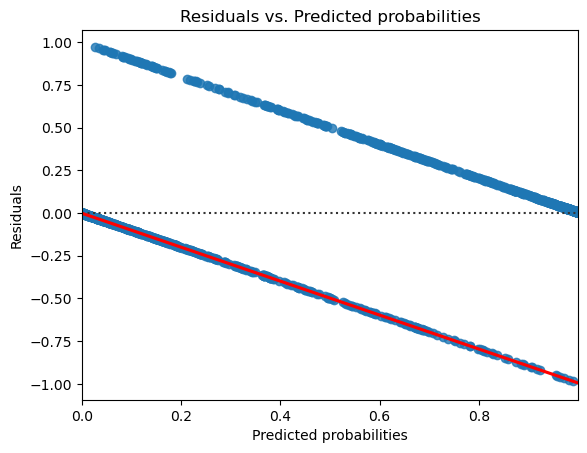

                        Feature        VIF
0            Absolute Magnitude   3.191466
1     Epoch Date Close Approach  40.213249
2  Relative Velocity km per sec   2.479110
3            Orbit Uncertainity   2.148833
4    Minimum Orbit Intersection   1.792271
5              Epoch Osculation   0.000043
6                  Eccentricity   1.937462
7                   Inclination   2.217291
8            Asc Node Longitude   1.003083
9           Perihelion Distance   1.754590
Optimization terminated successfully.
         Current function value: 0.124463
         Iterations 12


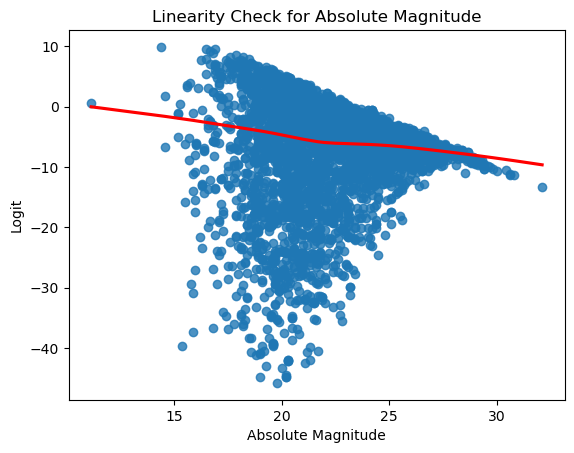

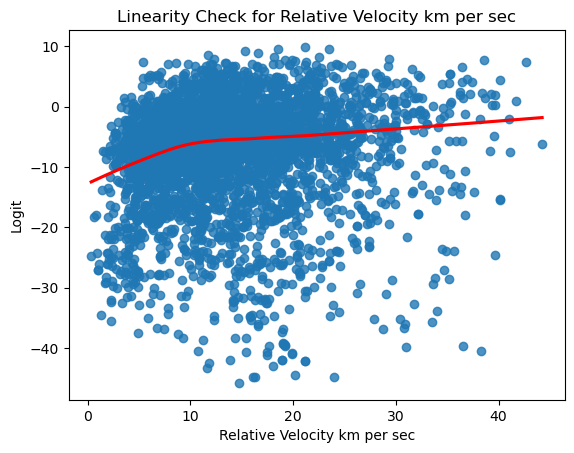

In [12]:
## Check Residual Plot
logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
pred_probs = logit_model.predict(sm.add_constant(X_train))
residuals = y_train - pred_probs
sns.residplot(x=pred_probs, y=residuals, lowess=True, line_kws={'color': 'red'})
plt.xlabel('Predicted probabilities')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted probabilities')
plt.show()

## Check for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]
print(vif_data)

## Check Linearity of the Logit for Specific Predictors
logit_model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
pred_probs = logit_model.predict(sm.add_constant(X_train))
logit_values = np.log(pred_probs / (1 - pred_probs))

features_to_check = ['Absolute Magnitude', 'Relative Velocity km per sec']

for feature in features_to_check:
    sns.regplot(x=X_train[feature], y=logit_values, lowess=True, line_kws={'color': 'red'})
    plt.xlabel(feature)
    plt.ylabel('Logit')
    plt.title(f'Linearity Check for {feature}')
    plt.show()

Using data from NASA's Center for NEO Studies, a logistic regression model was built to predict whether an asteroid is hazardous or not. Forward stepwise selection identified 'Absolute Magnitude' and 'Relative Velocity km per sec' as the most significant features. Principal Component Analysis (PCA) was applied to reduce dimensionality, selecting components that carry most of the variance. The model achieved a strong cross-validated accuracy of about 83.78%. Key assumptions of logistic regression, such as linearity of the logit, independence of errors, and absence of multicollinearity, were checked and met. The focus on 'Absolute Magnitude' and 'Relative Velocity km per sec' ensures a simple and effective model for predicting hazardous asteroids.